# English to Hinglish Generation

Here we are tryinh to generate Hinglish sentence by English sentence 

In [1]:
import pandas as pd

dfd = pd.read_csv('/kaggle/input/hinglish-dataset/dev.txt', names=['en', 'hing'], usecols=['en', 'hing'], sep='\t')
print(dfd.shape)
dfd = dfd.sample(frac=1, random_state=42)
dfd = dfd.reset_index(drop=True)
dfd.head()

(942, 2)


,en,hing
0,I agree. It seems like she holds back on her e...,mein bhi maantha hoon... voh apni emotions ach...
1,This movie looks really interesting I like Tom...,es cinema sachmuch kafi majedar thi mai Tom Ha...
2,I didn't like the scene where Mia left him at ...,Mujhe wo scene pasand nhi aaya jahan Mia ne us...
3,I enjoyed Morgan Freeman also but he is amazin...,mein Morgan freeman tho enjoy kar raha hoon au...
4,"Hello, sounds great","hello, great sound kar rahi he"


In [2]:
df1 = pd.read_csv("/kaggle/input/hinglish-dataset/ManualAnalysis.csv")
df1 = df1[["src", "tgt"]]
df1 = df1.rename(columns = {"src":"en", "tgt":"hing"})

In [3]:
df = pd.read_csv('/kaggle/input/hinglish-dataset/train.txt', names=['en', 'hing'], usecols=['en', 'hing'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,hing
0,Terrence Howard was also in it as James Rhodes...,james rhodes mein terrence howard they aur oba...
1,"I think an 9, it was a great movie, even if th...","Nine ,accha movie tha music jyada play hone ke..."
2,this film wanted to break the stereotype,is film tho stereotype ko break kar liya
3,"Okay, Night Fury freed Hiccup then?",Accha Night Fury Hiccup ko chhod deta hai phir
4,Sounds like a good kid.,acha ladka lagta hai


In [4]:
frames = [df, dfd, df1]
df = pd.concat(frames, ignore_index = True)
df.shape

(9902, 2)

In [5]:
df

,en,hing
0,Terrence Howard was also in it as James Rhodes...,james rhodes mein terrence howard they aur oba...
1,"I think an 9, it was a great movie, even if th...","Nine ,accha movie tha music jyada play hone ke..."
2,this film wanted to break the stereotype,is film tho stereotype ko break kar liya
3,"Okay, Night Fury freed Hiccup then?",Accha Night Fury Hiccup ko chhod deta hai phir
4,Sounds like a good kid.,acha ladka lagta hai
...,...,...
9897,it would be funny if it was still called f ace...,bahut funny hota agar ise abhi bhi facemash ka...
9898,"i would rate frozen as an 80%, or 8 out of 10.","main frozain0%, ya ratai mein se ratai ke roop..."
9899,the other person back out i am still here wast...,"dursa banda to chala gaya, mai abhi bhi hu, ho..."
9900,"i'd have to agree, but jonah hill really knock...","mein bhi maantha hoon, lekin johan hill tho re..."


In [6]:
import re
from unicodedata import normalize

def clean_text(text):
    text = text.lower()
    text = normalize('NFD', text)
    cleaned_text = ''
    for char in text:
        if char.isalpha() or char == ' ':
            cleaned_text += char
    return cleaned_text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['hing'] = df['hing'].apply(lambda row: clean_text(row))
df.head()

,en,hing
0,terrence howard was also in it as james rhodes...,james rhodes mein terrence howard they aur oba...
1,i think an it was a great movie even if the m...,nine accha movie tha music jyada play hone ke ...
2,this film wanted to break the stereotype,is film tho stereotype ko break kar liya
3,okay night fury freed hiccup then,accha night fury hiccup ko chhod deta hai phir
4,sounds like a good kid,acha ladka lagta hai


In [7]:
en = df['en']
hing = df['hing']

en_max_len = max(len(line.split()) for line in en)
hing_max_len = max(len(line.split()) for line in hing)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (Hinglish): {hing_max_len}')

Max phrase length (English): 247
Max phrase length (Hinglish): 337


In [17]:
from collections import defaultdict
import torch
class Tokenizer:
    def __init__(self):
        self.word_index = {}
        self.index_word = {}
    
    def fit_on_texts(self, texts):
        word_freq = defaultdict(int)
        for text in texts:
            for word in text.split():
                word_freq[word] += 1
        self.word_index = {word: i+1 for i, (word, freq) in enumerate(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))}
        self.index_word = {i: word for word, i in self.word_index.items()}

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            seq = [self.word_index.get(word, 0) for word in text.split()]
            sequences.append(seq)
        return sequences
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            words = [self.index_word.get(idx, "<unk>") for idx in sequence if idx > 0]  # Skip padding
            text = " ".join(words)
            texts.append(text)
        return texts

def pad_sequences(sequences, maxlen, padding='post'):
    max_seq_len = max(len(seq) for seq in sequences)
    padded_seqs = torch.zeros((len(sequences), maxlen), dtype=torch.long)
    for i, seq in enumerate(sequences):
        if padding == 'post':
            padded_seqs[i, :len(seq)] = torch.tensor(seq[:maxlen], dtype=torch.long)
        else:  
            padded_seqs[i, -len(seq):] = torch.tensor(seq[-maxlen:], dtype=torch.long)
    return padded_seqs

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=en_max_len, padding='post')

hing_tokenizer = Tokenizer()
hing_tokenizer.fit_on_texts(hing)
hing_sequences = hing_tokenizer.texts_to_sequences(hing)
hing_y = pad_sequences(hing_sequences, maxlen=hing_max_len, padding='post')


In [10]:
en_vocab_size = len(en_tokenizer.word_index) + 1
hing_vocab_size = len(hing_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (Hinglish): {hing_vocab_size}')

Vocabulary size (English): 6177
Vocabulary size (Hinglish): 9873


## Train a model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Seq2Seq(nn.Module):
    def __init__(self, en_vocab_size, hing_vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.embedding = nn.Embedding(en_vocab_size, 300)
        self.encoder = nn.LSTM(300, hidden_size)
        self.decoder = nn.LSTM(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, hing_vocab_size)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        embedded = self.embedding(x)
        encoded, (hidden, cell) = self.encoder(embedded)
        decoded = self.dropout(encoded)
        decoded, _ = self.decoder(decoded, (hidden, cell))
        output = self.linear(decoded)
        return output

torch.manual_seed(42)
np.random.seed(42)

hidden_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Seq2Seq(en_vocab_size, hing_vocab_size, hidden_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

en_x = torch.tensor(en_x, dtype=torch.long).to(device)
hing_y = torch.tensor(hing_y, dtype=torch.long).to(device)



/tmp/ipykernel_34/1893587008.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  en_x = torch.tensor(en_x, dtype=torch.long).to(device)
/tmp/ipykernel_34/1893587008.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hing_y = torch.tensor(hing_y, dtype=torch.long).to(device)


In [12]:
# Train the model
num_epochs = 50
batch_size = 8
validation_split = 0.2

accumulation_steps = 4
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()  
    for i in range(0, len(en_x), batch_size):
        inputs = en_x[i:i+batch_size]
        labels = hing_y[i:i+batch_size]

        outputs = model(inputs)
        outputs = outputs.permute(1, 0, 2)  
        outputs = outputs.reshape(-1, hing_vocab_size)  

        labels = labels.permute(1, 0)  
        flat_labels = labels.reshape(-1)

        if outputs.size(0) > flat_labels.size(0):
            outputs = outputs[:flat_labels.size(0), :]
        elif outputs.size(0) < flat_labels.size(0):
            flat_labels = flat_labels[:outputs.size(0)]

        loss = criterion(outputs, flat_labels)
        (loss / accumulation_steps).backward()  
        running_loss += loss.item()

        if (i // batch_size + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    running_loss /= (len(en_x) / batch_size)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}')
    train_losses.append(running_loss)

Epoch [1/50], Loss: 0.5805
Epoch [2/50], Loss: 0.3683
Epoch [3/50], Loss: 0.3623
Epoch [4/50], Loss: 0.3570
Epoch [5/50], Loss: 0.3514
Epoch [6/50], Loss: 0.3458
Epoch [7/50], Loss: 0.3401
Epoch [8/50], Loss: 0.3337
Epoch [9/50], Loss: 0.3270
Epoch [10/50], Loss: 0.3199
Epoch [11/50], Loss: 0.3127
Epoch [12/50], Loss: 0.3052
Epoch [13/50], Loss: 0.2975
Epoch [14/50], Loss: 0.2900
Epoch [15/50], Loss: 0.2823
Epoch [16/50], Loss: 0.2748
Epoch [17/50], Loss: 0.2677
Epoch [18/50], Loss: 0.2608
Epoch [19/50], Loss: 0.2543
Epoch [20/50], Loss: 0.2475
Epoch [21/50], Loss: 0.2416
Epoch [22/50], Loss: 0.2357
Epoch [23/50], Loss: 0.2301
Epoch [24/50], Loss: 0.2248
Epoch [25/50], Loss: 0.2197
Epoch [26/50], Loss: 0.2149
Epoch [27/50], Loss: 0.2102
Epoch [28/50], Loss: 0.2061
Epoch [29/50], Loss: 0.2016
Epoch [30/50], Loss: 0.1975
Epoch [31/50], Loss: 0.1935
Epoch [32/50], Loss: 0.1896
Epoch [33/50], Loss: 0.1858
Epoch [34/50], Loss: 0.1823
Epoch [35/50], Loss: 0.1792
Epoch [36/50], Loss: 0.1757
E

Plot the per-epoch training and validation accuracy:

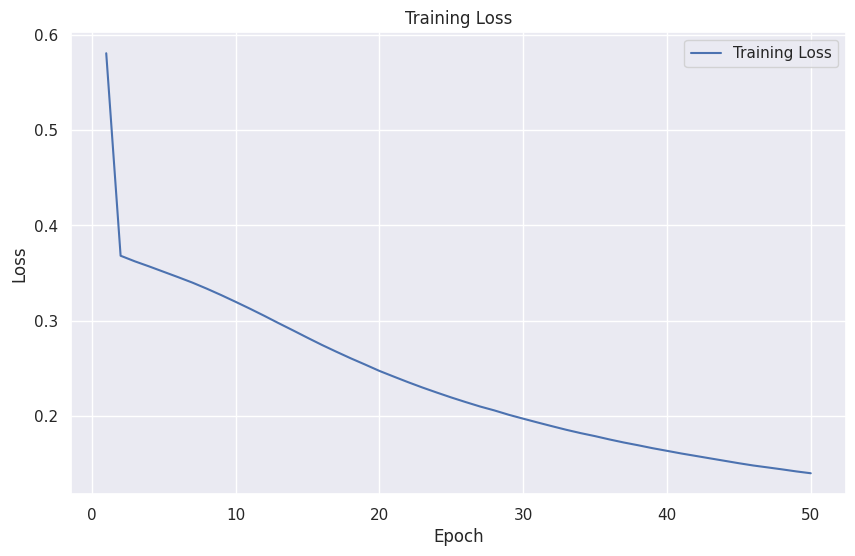

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, '-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


## Using model to translate text

In [18]:
def translate_text_pytorch(text, model, en_tokenizer, hing_tokenizer, en_max_len, device):
    # Tokenizing the input text
    sequence = en_tokenizer.texts_to_sequences([text])
    padded_sequence = torch.tensor(sequence, dtype=torch.long, device=device)  # Directly create tensor on device
    
    padded_sequence = padded_sequence.to(device).long()
    
    if len(padded_sequence.shape) == 1:
        padded_sequence = padded_sequence.unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        prediction = model(padded_sequence).squeeze(0)
    
    prediction = prediction.cpu().numpy()  # Move prediction to CPU for NumPy operations
    indexes = [np.argmax(idx) for idx in prediction]
    translated_text = hing_tokenizer.sequences_to_texts([indexes])[0]
    
    return translated_text

texts = en[1000: 1010].tolist()  
for text in texts:
    translated = translate_text_pytorch(text, model, en_tokenizer, hing_tokenizer, en_max_len, device)
    print(f'{text} => {translated}')

no sadly i do not know what it is about i do know that sebastian does not enjoy the music his band plays in  => no the i tumko koi know john ye hai mein i tumko know hai me jisase koi moive jiya samjh nikla poorn titile isliye
what do the critics say about it => john tumko jiya critics ne mein ye
hi => hi
oh => oh
a retired killer => school status hoya
as a child bruce wayne falls down into a dry well and is attacked by a swarm of bats subsequently developing a phobia of the creatures while watching an opera with his parents thomas and martha bruce becomes frightened by performers masquerading as bats and asks to leave outside mugger joe chill murders bruces parents in front of him orphaned bruce is raised by the family butler alfred pennyworth => gary school kholne emaee imdb yakin badee school niraashaajanak well and hai aankh nai school stane describe direction maine school replaced describe jiya illumination mein mein action miley hop nikla nominated maleficent and lagta kholne cha

In [19]:
# Translating "you are good"
translated_text = translate_text_pytorch('you are good', model, en_tokenizer, hing_tokenizer, en_max_len, device)
print(translated_text)

aapane kaunsa good


The model isn't perfect, but it's not bad, either. It is learning, part correctly, but may be the dataset it very small so it is not able to learn properly, the structure of hinglish